# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

# Setup

In [33]:
gradient=False

In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
import sys
sys.path.append("../")

In [35]:
# If Jedi's not working
%config Completer.use_jedi = False

In [36]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'dev-notebooks'/'data'/'drug'
RAWDATA = DATA/'raw'
LOCALDATA = DATA/'interim'

if gradient:
    IMGDATA = Path('/storage/molimages')
else:
    # Path to image data as defined earlier
    IMGDATA = Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages')

In [37]:
from fastai.vision.all import *

# Load data

In [59]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = "_".join(str(data.stem).split("_")[:2])
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [60]:
# Datasets available:
data = sorted(list(LOCALDATA.ls(file_exts='.csv')))
data

[Path('/home/alex/dropbox-ssd/Dropbox/Jobb/HIB/Kurs/NORBIS2021/repo/NORBIS-DL-2021/dev-notebooks/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv')]

...and that we've generated images of the molecules:

In [61]:
IMGDATA.ls()

(#7) [Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL301_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL218_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL205_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL240_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL244_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL219_cl'),Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages/CHEMBL1978_cl')]

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [62]:
ds = data[0]
ds

Path('/home/alex/dropbox-ssd/Dropbox/Jobb/HIB/Kurs/NORBIS2021/repo/NORBIS-DL-2021/dev-notebooks/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv')

In [63]:
df, name = get_df(ds)

In [43]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       6831 non-null   object
 1   SMILES    6831 non-null   object
 2   Image     6831 non-null   object
 3   Activity  6831 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 213.6+ KB


In [45]:
df['Activity'].value_counts()

0    6210
1     621
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [71]:
df = val_cols_and_oversample(df)

In [72]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False
1,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False
2,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False
3,CHEMBL1957218,s1cc(nc1-c1ccncc1C)-c1cccnc1,CHEMBL1957218.png,1,False
4,CHEMBL1957223,s1cc(nc1-c1cccnc1)-c1ccc(OC)nc1,CHEMBL1957223.png,1,False


In [73]:
df['Activity'].value_counts()

0    6210
1    4815
Name: Activity, dtype: int64

# Create a dataloader

In [74]:
bs=64

In [75]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [76]:
IMGDATA

Path('/home/alex/data-tmp/drugdiscovery/MOESM/molimages')

In [77]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [78]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

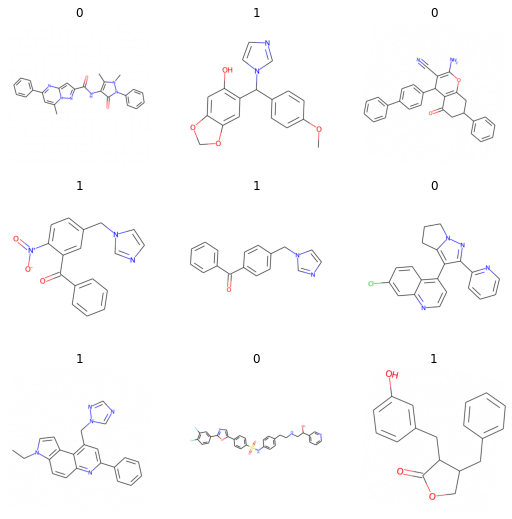

In [79]:
dls.show_batch()

# Train a CNN

In [80]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [81]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [82]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [83]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

The below training takes a while. We can rather load the results of a previous run:

In [31]:
#learn = learn.load('chembl1978-model-test-hooks')

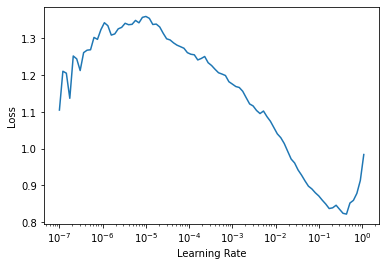

In [86]:
lr_min, lr_steep = learn.lr_find(suggestions=True)

In [87]:
lr = lr_min/10
lr

0.0043651583790779115

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.206131,0.140404,0.954918,0.780627,0.698980,0.883871,0.974871,0.762353,01:09


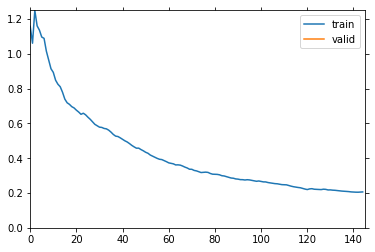

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.142610,0.400315,0.868852,0.553785,0.400576,0.896774,0.957304,0.544617,01:21
1,0.126351,0.223875,0.919204,0.680556,0.530686,0.948387,0.978163,0.673824,01:28
2,0.092541,0.120893,0.964286,0.827195,0.737374,0.941935,0.981705,0.815140,01:27
3,0.081528,0.098728,0.970726,0.822695,0.913386,0.748387,0.975943,0.811671,01:26
4,0.059191,0.084993,0.974824,0.866044,0.837349,0.896774,0.981069,0.852778,01:29
5,0.034590,0.090343,0.977166,0.876972,0.858025,0.896774,0.983549,0.864650,01:24
6,0.021929,0.094478,0.976581,0.874214,0.852761,0.896774,0.984230,0.861643,01:29
7,0.012595,0.095701,0.977752,0.878205,0.872611,0.883871,0.984301,0.865985,01:29


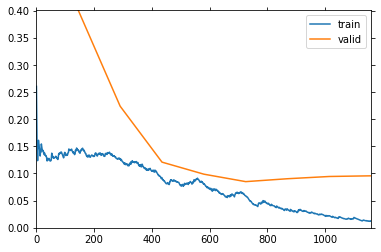

In [88]:
learn.freeze()
learn.fit(1, lr)
learn.unfreeze()
learn.fit_one_cycle(8, slice(lr))

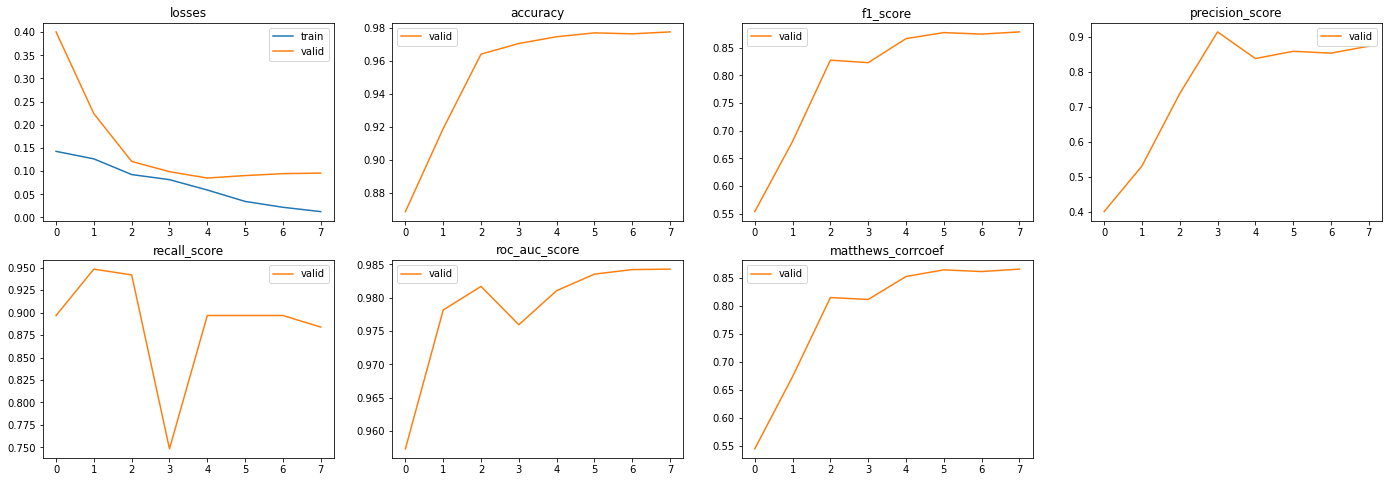

In [89]:
learn.recorder.plot_metrics()

In [90]:
learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [91]:
interp = ClassificationInterpretation.from_learner(learn)

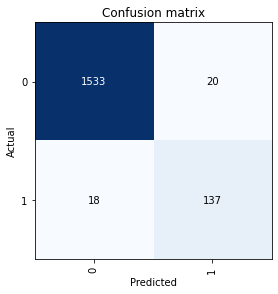

In [92]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a "hook" at the layer we want to save activations from:

In [93]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [94]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [95]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [96]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [97]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [98]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [99]:
test_df = test_dls.items.reset_index()

In [100]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,4108,CHEMBL2322164,O(C)c1ccc(cc1C#N)-c1nc(nc(O)c1)N,CHEMBL2322164.png,0,False
1,395,CHEMBL598224,n1cn(nc1)Cc1cc(cc(c1)C(C#N)(C)C)-c1ccccc1,CHEMBL598224.png,1,False
2,5616,CHEMBL55240,Clc1ccc(cc1)COCC([NH2+]Cc1ccccc1)C(=O)N1CCC2(CC1)c1c(N(S(=O)(=O)C)C2)cccc1,CHEMBL55240.png,0,False
3,4713,CHEMBL2386393,Fc1ccc(cc1)C=1Oc2c(C(=O)C=1)c(O)ccc2,CHEMBL2386393.png,0,False
4,1811,CHEMBL1097355,S(=O)(=O)(N1CC([NH2+]CC1)C(O)C(NC(=O)c1cc(cc(c1)C)C(=O)N1CCCC1COC)Cc1cc(F)cc(F)c1)C,CHEMBL1097355.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [101]:
test_dls.dataset[0]

(PILImage mode=RGB size=500x500, TensorCategory(0))

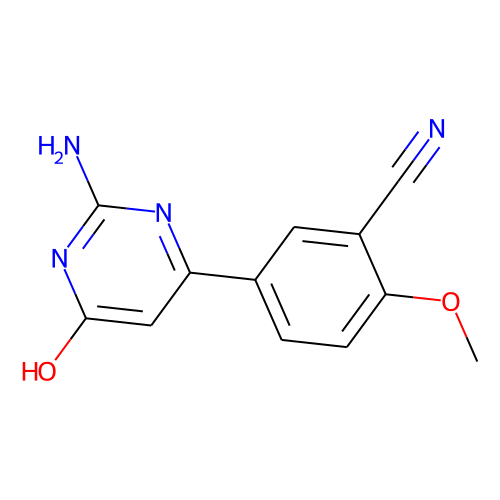

In [102]:
test_dls.dataset[0][0]

In [103]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [104]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [106]:
#df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')
#df_acts.head()

In [107]:
%%time
%%capture
df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

CPU times: user 32min 59s, sys: 32.7 s, total: 33min 31s
Wall time: 2min 6s


Now we've stored activations for each image:

In [108]:
#df_nodupl.head()

We split the activations to have one column for each, as they will be treated as separate features later:

In [109]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [110]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [111]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,21.969614,0.980733,-8.351092,3.059582,12.877200,...,-6.979407,-9.618112,-9.312126,12.365116,-6.620613,15.832842,-4.545561,6.162177,12.743739,7.451705
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,25.143867,8.225955,4.945821,-1.957085,12.573187,...,0.929786,-26.707027,-3.074286,16.768356,-15.157301,21.127239,-18.667513,8.938683,11.758362,12.501764
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,16.160198,-6.924146,-21.413534,8.937335,13.210670,...,-12.025540,15.264744,-12.211967,4.306020,7.869371,4.839438,15.098200,2.385348,16.724010,0.409003
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,29.369150,-6.487902,-2.362982,3.152086,7.199418,...,-10.971612,-10.871054,-10.700091,3.004363,-8.731466,28.115818,-13.888570,2.856269,21.273628,9.977045
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,33.179134,-7.594040,-6.331515,4.469067,9.668778,...,-11.808960,-11.515196,-14.737844,4.102236,-9.220325,30.577158,-12.345279,4.163447,23.914942,10.393492


In [112]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float64(128), int64(1), object(4)
memory usage: 6.9+ MB


In [113]:
df_acts.to_csv('data/chembl1978_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `dev-noteboos/DL-Example-3-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [114]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [115]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


In [117]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float64(128), int64(1), object(4)
memory usage: 6.9+ MB


In [118]:
df = df_ecfp.merge(df_acts, on='CID')

In [119]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-6.979407,-9.618112,-9.312126,12.365116,-6.620613,15.832842,-4.545561,6.162177,12.743739,7.451705
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0.929786,-26.707027,-3.074286,16.768356,-15.157301,21.127239,-18.667513,8.938683,11.758362,12.501764
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-12.025540,15.264744,-12.211967,4.306020,7.869371,4.839438,15.098200,2.385348,16.724010,0.409003
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-10.971612,-10.871054,-10.700091,3.004363,-8.731466,28.115818,-13.888570,2.856269,21.273628,9.977045
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-11.808960,-11.515196,-14.737844,4.102236,-9.220325,30.577158,-12.345279,4.163447,23.914942,10.393492


In [120]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [121]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-6.979407,-9.618112,-9.312126,12.365116,-6.620613,15.832842,-4.545561,6.162177,12.743739,7.451705
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0.929786,-26.707027,-3.074286,16.768356,-15.157301,21.127239,-18.667513,8.938683,11.758362,12.501764
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-12.025540,15.264744,-12.211967,4.306020,7.869371,4.839438,15.098200,2.385348,16.724010,0.409003
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-10.971612,-10.871054,-10.700091,3.004363,-8.731466,28.115818,-13.888570,2.856269,21.273628,9.977045
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-11.808960,-11.515196,-14.737844,4.102236,-9.220325,30.577158,-12.345279,4.163447,23.914942,10.393492


In [122]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [123]:
LOCALDATA

Path('/home/alex/dropbox-ssd/Dropbox/Jobb/HIB/Kurs/NORBIS2021/repo/NORBIS-DL-2021/dev-notebooks/data/drug/interim')

In [124]:
df.to_csv('data/chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [125]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [126]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [127]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [128]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,0.929786,-26.707027,-3.074286,16.768356,-15.157301,21.127239,-18.667513,8.938683,11.758362,12.501764
3,0,0,0,0,0,0,0,0,0,0,...,-10.971612,-10.871054,-10.700091,3.004363,-8.731466,28.115818,-13.888570,2.856269,21.273628,9.977045
4,0,0,0,0,0,0,0,0,0,0,...,-11.808960,-11.515196,-14.737844,4.102236,-9.220325,30.577158,-12.345279,4.163447,23.914942,10.393492
5,0,0,0,0,0,0,0,0,0,0,...,-5.761273,-12.824088,-11.573144,14.212199,-10.028303,18.587492,-7.925244,7.563968,12.923626,11.964258
8,0,0,0,0,0,0,0,0,0,0,...,1.266608,-10.652791,-7.206377,14.728067,-6.748971,10.780285,-6.509335,4.362518,11.612720,8.704054


In [129]:
y_train.head()

1    1
3    1
4    1
5    1
8    1
Name: Activity, dtype: int64

### Logistic Regression and Random forest

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [131]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [138]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f'AUC: {auc}')
    print(f'Accuracy: {acc2}')
    print(f'MCC: {mcc}')
    print(f'Recall: {Recall}')
    print(f'Precision: {Precision}')
    print(f'F1_score: {F1_score}')

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [139]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=100)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f'AUC: {auc}')
    print(f'Accuracy: {acc2}')
    print(f'MCC: {mcc}')
    print(f'Recall: {Recall}')
    print(f'Precision: {Precision}')
    print(f'F1_score: {F1_score}')

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [141]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.9844421826641464
Accuracy: 0.9754098360655737
MCC: 0.8518754972513235
Recall: 0.8709677419354839
Precision: 0.8598726114649682
F1_score: 0.8653846153846154


In [142]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.9835947074341026
Accuracy: 0.9795081967213115
MCC: 0.8711351411544176
Recall: 0.832258064516129
Precision: 0.9347826086956522
F1_score: 0.8805460750853243


In [144]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.9836320960471927
Accuracy: 0.9795081967213115
MCC: 0.872440261077636
Recall: 0.8516129032258064
Precision: 0.9166666666666666
F1_score: 0.882943143812709


**Random forest:**

In [145]:
_ = train_rf(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.9922896371227384
Accuracy: 0.9795081967213115
MCC: 0.8705086999500459
Recall: 0.8193548387096774
Precision: 0.9477611940298507
F1_score: 0.8788927335640139


In [146]:
_ = train_rf(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.9655858587956712
Accuracy: 0.9742388758782201
MCC: 0.8390791502712486
Recall: 0.8193548387096774
Precision: 0.8881118881118881
F1_score: 0.8523489932885905


In [147]:
_ = train_rf(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.9680202729368754
Accuracy: 0.974824355971897
MCC: 0.8430977916793885
Recall: 0.8258064516129032
Precision: 0.8888888888888888
F1_score: 0.8561872909698998
